In [658]:
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
%matplotlib inline

In [660]:
%run 82_label_modifying.ipynb

/home/arleg/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [661]:
def find_diff(df):
    """
    Find number of rows for metainformation in df. This rows should located at the bottom of df
    Assumes that only peak names contains numbers
    Used for finding constant meta
    :param df: df - dataframe with metadata
    :return: int - number of rows which are taken by metadata
    """
    meta = df.shape[0] - df.filter(regex=r'\d+', axis=0).index.shape[0]
    return meta

Scheme:
* define indexing constants
* subset the df
* analysis
* plot

In [662]:
def subset(df, include, exclude={}, with_mass=True):
    """
    Take appropriate slice of data, use samples_with_mass constant which should be predefined. 
    At least one of include and exclude should be provided, could be both
    :param df: df - dataframe merged with metadata
    :param include: dict - dictionary with feature: variant to include variant of feature from output df
                           other appropriate format is feature: [variants] to include all listed variants
    :param exclude: dict - dictionary with feature: variant to exclude variant of feature from output df
                           other appropriate format is feature: [variants] to exclude all listed variants
    :param with_mass: boolean - whether to exclude samples without known mass,
                                idk why I have included this option - it always should be True
    :return: df - subset of input df
    """
    # Create a copy of original df
    df = df.copy()
    # Initialize condition with neutral element
    cond = True

    # For features in include add to condition appropriate columns
    for feature, variant in include.items():
        # Add single variant
        if type(variant) is str:
            cond &= (df.loc[feature] == variant)
        # Add several variants
        else:
            cond &= df.loc[feature].isin(variant)
    
    # For features in include add to condition appropriate columns
    for feature, variant in exclude.items():
            # Remove single variant
            if type(variant) is str:
                cond &= (df.loc[feature] != variant)
            # Remove several variants
            else:
                cond &= ~df.loc[feature].isin(variant)
    
    # Imho this condition is always true, hence with_mass parameter should be removed
    # Take only columns with present mass
    if with_mass:
        return df.loc[:, cond & samples_with_mass]
    # Take all selected columns
    return df.loc[:, cond]

In [663]:
# Obsolete
# def subset(df, sample_feature, sample_feature_variant, exclude={}, with_mass=True):
#     """
#     Take appropriate slice of data, use samples_with_mass constant which should be predefined
#     :param df: df - dataframe merged with metadata
#     :param sample_feature: str - index of row containing variant which will be chosen
#     :param sample_feature_variant: str - variant in sample_feature which will be chosen
#     :param exclude: dict - dictionary with sample_feature: sample_feature_variant to exclude from output df
#                            other appropriate format is sample_feature: [sample_feature_variant]
#     :param with_mass: boolean - whether to exclude samples without known mass,
#                                       idk why I include this option - it always should be True
#     :return: df - subset of input df
#     """
#     # Create a copy of original df
#     df = df.copy()

#     # Iterate over features and variants in exclude dict and remove these variants from df
#     for feature, variant in exclude.items():
#         # Remove single variant
#         if type(variant) is str:
#             df.drop(df.loc[:, (df.loc[feature] == variant)].columns, axis=1, inplace=True)
#         # Remove several variants
#         else:
#             df = df.loc[:, ~df.loc[feature].isin(variant)]

#     # Select samples with specified variant of feature
#     # Take only columns with present mass
#     if with_mass:
#         return df.loc[:, (df.loc[sample_feature] == sample_feature_variant) & samples_with_mass]
#     # Take all selected columns
#     else:
#         return df.loc[:, (df.loc[sample_feature] == sample_feature_variant)]

    
def extract_data_for_plot(df, sample_feature):
    """
    Take label series of data and all unique possible variants of this label type
    :param df: df - part of samples from dataframe merged with metadata
    :param sample_feature: str - index of row containing variants by which samples will be divided on the plot
    :return: df - subset of input df
    """
    # Take series
    y = df.loc[sample_feature]
    # Take unique variants
    classes = df.loc[sample_feature].unique()
    return y, classes

In [664]:
def pca_transform(df, n_components=2):
    """
    Transform data for PCA, meta constant should be predefined
    :param df: df - subset of dataframe merged with metadata
    :param n_components: int - number of components
    :return: array - np array with number of samples x n_components shape 
    """
    # Initialize transformer
    pca = PCA(n_components=n_components)
    # Take numeric subset of data and
    # Transpose df, because as we love in ml ROWS are observations and COLUMNS are features and
    # all normal functions follow this convention. Thus we finally transpose df to normal form
    transformed = pca.fit_transform(df.iloc[:-meta].T)
    # Display info about percantages
    variance = pca.explained_variance_ratio_
    print('Explained var is ', *tuple(map(lambda x: np.round(x, 2), variance)))
    return transformed

In [665]:
def mds_transform(df, n_components=2):
    """
    Transform data for MDS, meta constant should be predefined
    :param df: df - subset of dataframe merged with metadata
    :param n_components: int - number of components
    :return: array - np array with number of samples x n_components shape
    """
    # Initialize transformer
    mds = MDS(n_components=n_components, n_jobs=-1)
    # Take numeric subset of data and
    # Transpose df, because as we love in ml ROWS are observations and COLUMNS are features and
    # all normal functions follow this convention. Thus we finally transpose df to normal form
    transformed = mds.fit_transform(df.iloc[:-meta].T)
    return transformed

In [666]:
def draw_dimensionality_reduction(name, transformed, y, classes, colors=None, title='PCA', locus='best'):
    """
    Plot results of dimensionality collapsing
    :param name: str - name of saved figure
    :param transformed: array - 2d array with transformed data
    :param y: sequence - collection of observation labels e.g. old/young for age, bones/blood for tiessue etc.
    :param classes: sequence - container with unique labels of observations
    :param colors: sequence - container with colors in #HHHHHH format where H is a hex digit
    :param title: str - title of figure
    :param locus: str - position of legend
    :return:
    """
    # Specify plot size
    plt.figure(figsize=(12, 8))

    # Use specified colors if provided
    if colors:
        for sp, color in zip(classes, colors):
            plt.scatter(transformed[sp == y, 0],
                        transformed[sp == y, 1],
                        alpha=0.8, color=color, label=sp)
    else:
        for sp in classes:
            plt.scatter(transformed[sp == y, 0],
                        transformed[sp == y, 1],
                        alpha=0.8, label=sp)

    # Metadata
    xlab = 'PC1'
    ylab = 'PC2'
    plt.legend(loc=locus, shadow=False)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)

    # Create dir for images and save svg image
    os.makedirs('img', exist_ok=True)
    plt.savefig(f'img/{name}', format='svg', bbox_inches='tight')

## Example of usage with drawing PCA

In [657]:
df.loc['mass', samples].isna()

/home/arleg/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


X2018.06.07_rats_MS12_Brain.PFC._neg    False
X2018.06.07_rats_MS17_Brain.CB._neg     False
X2018.06.07_rats_MS20_Brain.PFC._neg    False
X2018.06.07_rats_MS61_Plasma_neg         True
X2018.06.07_rats_MS66_Plasma_neg         True
X2018.06.07_rats_MS29_Brain.PFC._neg    False
X2018.06.07_rats_MS3_Brain.CB._neg      False
X2018.06.07_rats_MS10_Brain.CB._neg     False
X2018.06.07_rats_MS4_Brain.CB._neg      False
X2018.06.07_rats_QC.pre.d_neg            True
X2018.06.07_rats_MS54_Muscle_neg        False
X2018.06.07._rats_ExtrBlank.5            True
X2018.06.07_rats_MS33_Brain.PFC._neg    False
X2018.06.07_rats_QC.3_brain_neg          True
X2018.06.07_rats_MS82_Liver_neg         False
X2018.06.07_rats_MS26_Brain.PFC._neg    False
X2018.06.07_rats_MS19_Brain.PFC._neg    False
X2018.06.07_rats_MS8_Brain.CB._neg      False
X2018.06.07_rats_MS47_Muscle_neg        False
X2018.06.07_ACNblank.4                   True
X2018.06.07._rats_ExtrBlank.1            True
X2018.06.07_rats_MS15_Brain.CB._ne

In [668]:
# Load data
name = 'normalized_with_meta_log_transformed_substituted_NA_cleaned_control_cleaned_isotopes_cleaned_contaminants_xs_annotated_rats_neg.csv'
df = pd.read_csv(name, index_col=0)

# Preliminaries
# Whether samples contain mass
samples_with_mass = ~df.loc['mass', samples].isna()
# Find number of rows with metadata in df
meta = find_diff(df)
# Dict with name: function of transformation functions
functions = {'pca': pca_transform, 'mds': mds_transform}

/home/arleg/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Explained var is  0.64 0.12


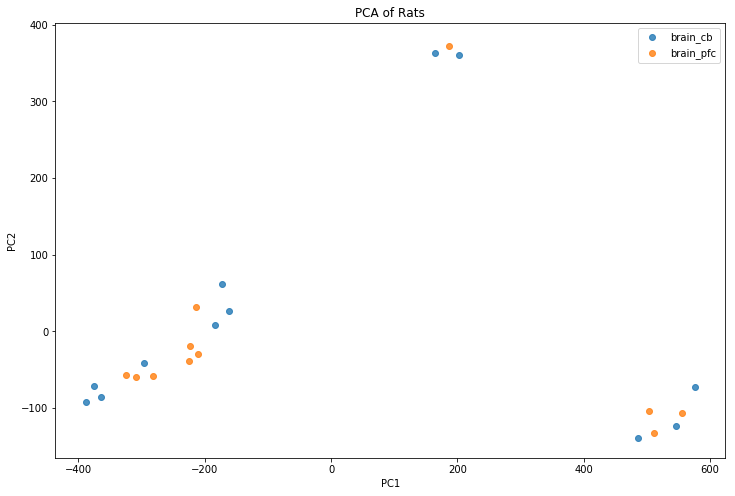

In [669]:
# Specify analysis name and species for selecting transformation and constructing title
analysis = 'pca'
species = 'rats'
# Create title
title = f'{analysis.upper()} of {species.capitalize()}'

# Specify included or excluded variants or both (seems like 1 of them is usually enough)
included_variants = {'age': 'old', 'tissue': ['brain_pfc', 'brain_cb']}
excluded_variants = {'tissue': ['liver', 'muscle']}

# Specify feature which will be used for differentiation of samples on the plot (different color)
separation_feature = 'tissue'

# Take appropriate subset of data
ss = subset(df, included_variants, excluded_variants)
# Extract y and classes for plot
y, classes = extract_data_for_plot(ss, separation_feature)
# Transform selected samples with PCA or MDS or something else
transformed = functions[analysis](ss)

# Draw and save plot
draw_dimensionality_reduction(title, transformed, y, classes, title=title)

### Draw PCA and MDS of each tissue for all ages

Explained var is  0.61 0.15
Explained var is  0.68 0.11
Explained var is  0.48 0.14
Explained var is  0.34 0.12
Explained var is  0.59 0.12


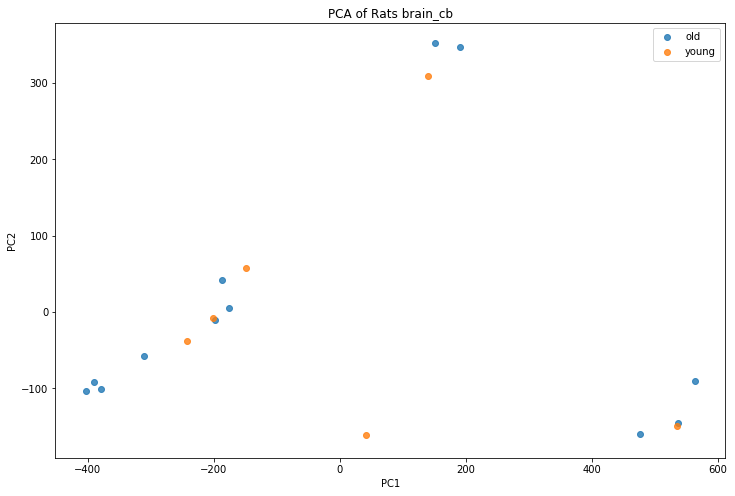

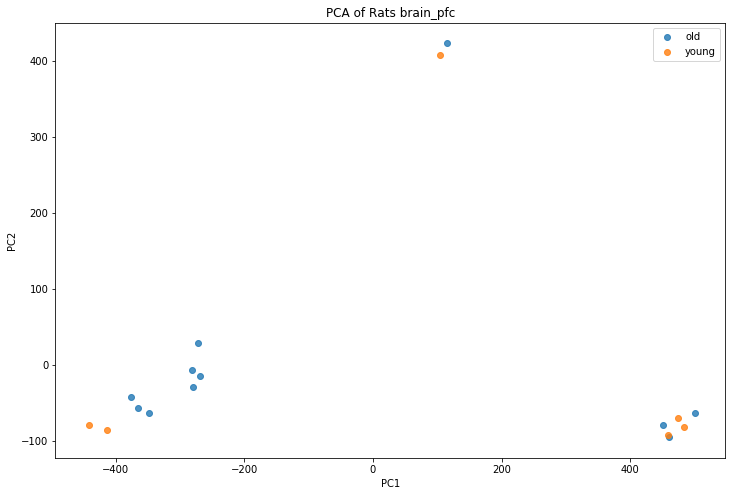

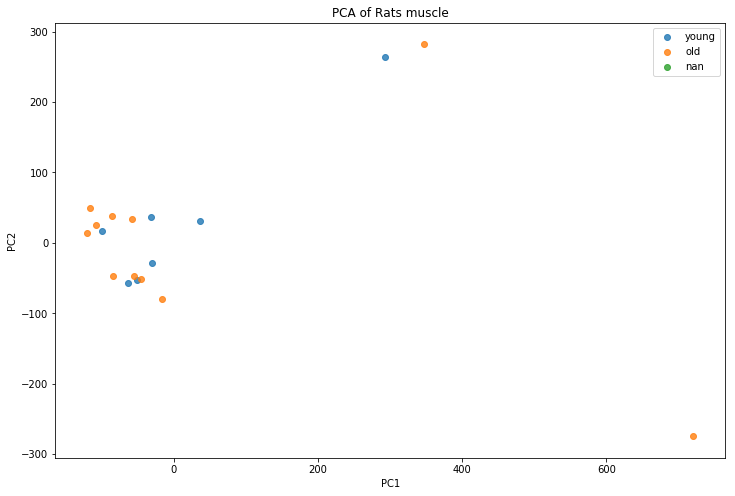

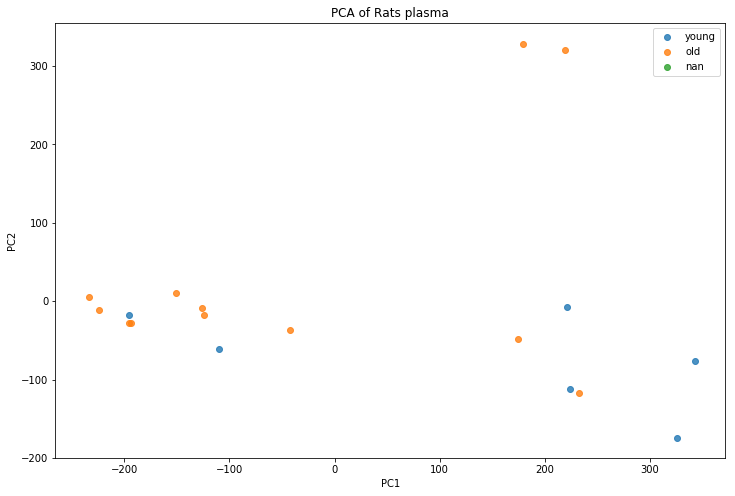

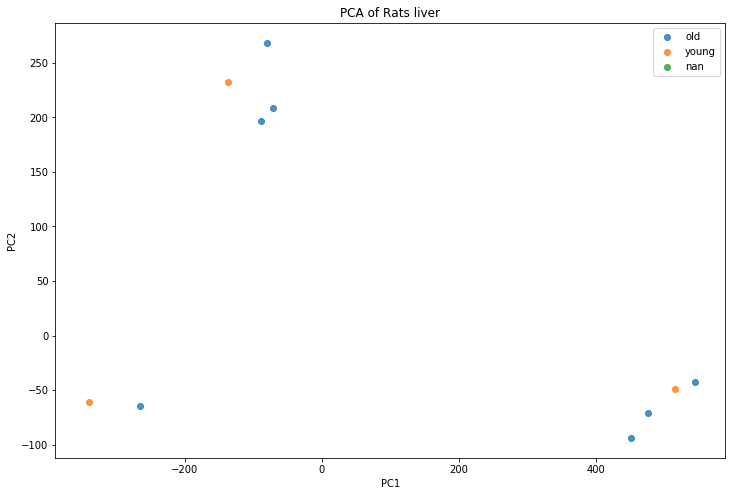

In [683]:
for tissue in ['brain_cb', 'brain_pfc', 'muscle', 'plasma', 'liver']:
    if tissue is np.nan:
        continue
    # Specify feature which will be used for differentiation of samples on the plot (different color)
    separation_feature = 'age'

    # Take appropriate subset of data
    ss = subset(df, {'tissue': tissue}, with_mass=False)
    # Extract y and classes for plot
    y, classes = extract_data_for_plot(ss, separation_feature)
    # Transform selected samples with PCA or MDS or something else
    transformed = functions[analysis](ss)

    # Draw and save plot
    draw_dimensionality_reduction(title + f'{title} {tissue}', transformed, y, classes, title=f'{title} {tissue}');
    plt.figure();

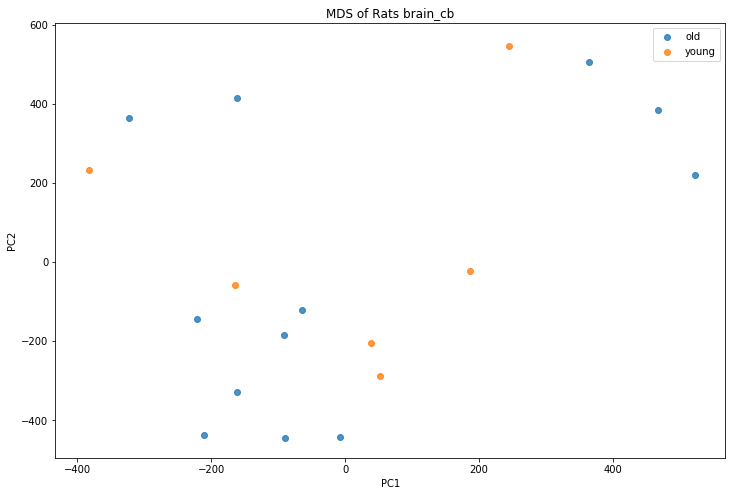

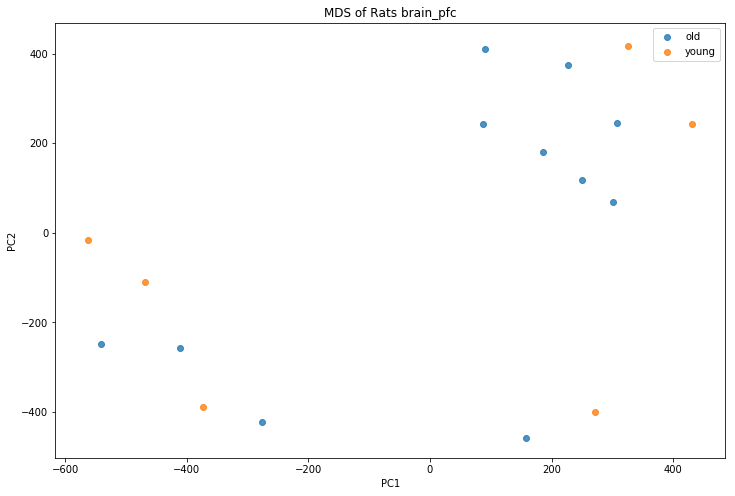

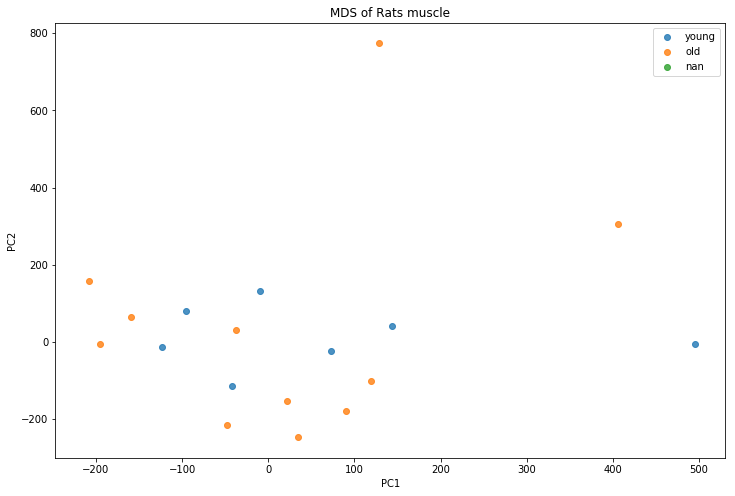

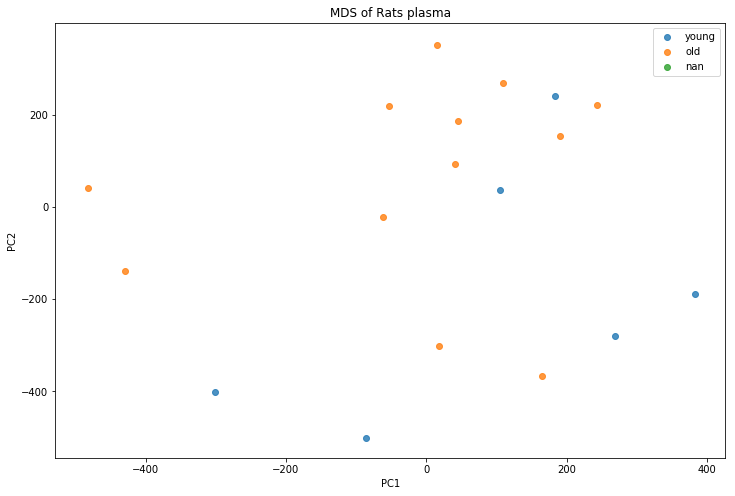

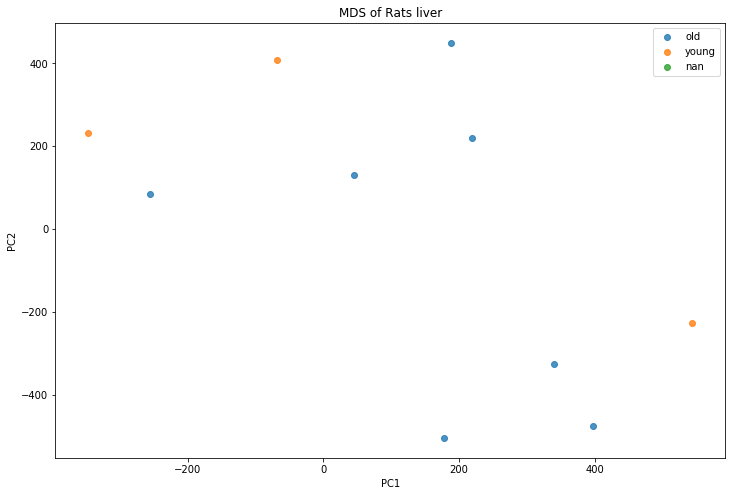

In [689]:
analysis = 'mds'
title = f'{analysis.upper()} of {species.capitalize()}'
for tissue in ['brain_cb', 'brain_pfc', 'muscle', 'plasma', 'liver']:
    if tissue is np.nan:
        continue
    # Specify feature which will be used for differentiation of samples on the plot (different color)
    separation_feature = 'age'

    # Take appropriate subset of data
    ss = subset(df, {'tissue': tissue}, with_mass=False)
    # Extract y and classes for plot
    y, classes = extract_data_for_plot(ss, separation_feature)
    # Transform selected samples with PCA or MDS or something else
    transformed = functions[analysis](ss)

    # Draw and save plot
    draw_dimensionality_reduction(f'{title} {tissue}', transformed, y, classes, title=f'{title} {tissue}')
    plt.figure();